<a href="https://colab.research.google.com/github/Tawhidis007/mask-detection/blob/main/mask_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader, Dataset
import os 
from PIL import Image
import random
import xml.etree.ElementTree as ET
import time
import requests

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# path of images directory
dir_path = '/content/gdrive/MyDrive/img data/images'

# path of xml files directory
xml_path = '/content/gdrive/MyDrive/img data/annotations'

# List of Image file name 
file_list = os.listdir(dir_path)

# How many image files?
print('There are total {} images.'.format(len(file_list)))

There are total 853 images.


In [4]:
# Helper function for read the data (label and bounding boxes) from xml file 
def read_annot(file_name, xml_dir):
    """
    Function used to get the bounding boxes and labels from the xml file
    Input:
        file_name: image file name
        xml_dir: directory of xml file
    Return:
        bbox : list of bounding boxes
        labels: list of labels
    """
    bbox = []
    labels = []
    
    annot_path = os.path.join(xml_dir, file_name[:-3]+'xml')
    tree = ET.parse(annot_path)
    root = tree.getroot()
    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)
        label = boxes.find('name').text
        bbox.append([xmin,ymin,xmax,ymax])
        if label == 'with_mask':
            label_idx = 2
        else:
            label_idx = 1
        labels.append(label_idx)
        
    return bbox, labels

# help function for drawing bounding boxes on image
def draw_boxes(img, boxes,labels, thickness=1):
    """
    Function to draw bounding boxes
    Input:
        img: array of img (h, w ,c)
        boxes: list of boxes (int)
        labels: list of labels (int)
    
    """
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for box,label in zip(boxes,labels):
        box = [int(x) for x in box]
        if label == 2:
            color = (0,225,0) # green
        elif label == 1:
            color = (0,0,225) # red
        cv2.rectangle(img, (box[0],box[1]),(box[2],box[3]),color,thickness)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

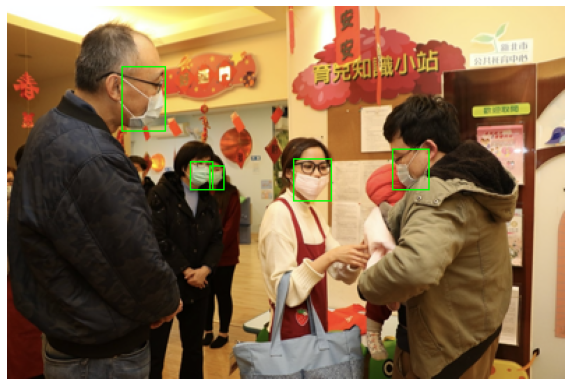

In [5]:
# Get the image randomly
image_name = file_list[random.randint(0,len(file_list))] # random select an image

# Get the bbox and label
bbox, labels  = read_annot(image_name, xml_path)

#draw bounding boxes on the image
img = draw_boxes(plt.imread(os.path.join(dir_path,image_name)), bbox,labels)
    
# display the image
fig, ax = plt.subplots(1,1,figsize=(10,10))
plt.axis('off')
ax.imshow(img)

In [6]:
class image_dataset(Dataset):
    def __init__(self, image_list, image_dir, xml_dir):
        self.image_list = image_list
        self.image_dir = image_dir
        self.xml_dir = xml_dir
       
    def __getitem__(self, idx):
        """
        Load the image
        """
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transforms.ToTensor()(img)

        """
        build the target dict
        """
        bbox, labels = read_annot(img_name, self.xml_dir)
        boxes = torch.as_tensor(bbox, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        
        area = (boxes[:,2] - boxes[:,0]) * (boxes[:,3] - boxes[:,1])
        area = torch.as_tensor(area, dtype=torch.float32)
        iscrowd = torch.zeros((len(bbox),), dtype=torch.int64)
        
        target = {}
        
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowed'] = iscrowd
        return img , target
                    
    def __len__(self):
        return len(self.image_list)

In [7]:
mask_dataset = image_dataset(file_list, dir_path, xml_path)

def collate_fn(batch):
    return tuple(zip(*batch))

mask_loader = DataLoader(mask_dataset,
                        batch_size=2,
                        shuffle=True,
                        num_workers=2,
                        collate_fn=collate_fn)

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [10]:
num_classes = 3 # background, without_mask, with_mask

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [11]:
# Setting the optimizer, lr_scheduler, epochs

params = [p for p in model.parameters() if p.requires_grad]
#optimizer = torch.optim.Adam(params, lr=0.01)
optimizer = torch.optim.SGD(params, lr=0.01,momentum=0.9, weight_decay=0.0005)
#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs=30

In [12]:
# Main training function
loss_list = []

for epoch in range(num_epochs):
    print('Starting training....{}/{}'.format(epoch+1, num_epochs))
    loss_sub_list = []
    start = time.time()
    for images, targets in mask_loader:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
        
        model.train()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        loss_sub_list.append(loss_value)
        
        # update optimizer and learning rate
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        #lr_scheduler.step()
    end = time.time()
        
    #print the loss of epoch
    epoch_loss = np.mean(loss_sub_list)
    loss_list.append(epoch_loss)
    print('Epoch loss: {:.3f} , time used: ({:.1f}s)'.format(epoch_loss, end-start))

Starting training....1/30
Epoch loss: 0.401 , time used: (633.6s)
Starting training....2/30
Epoch loss: 0.288 , time used: (266.2s)
Starting training....3/30
Epoch loss: 0.249 , time used: (267.7s)
Starting training....4/30
Epoch loss: 0.210 , time used: (268.4s)
Starting training....5/30
Epoch loss: 0.194 , time used: (267.7s)
Starting training....6/30
Epoch loss: 0.177 , time used: (267.3s)
Starting training....7/30
Epoch loss: 0.163 , time used: (268.1s)
Starting training....8/30
Epoch loss: 0.154 , time used: (266.7s)
Starting training....9/30
Epoch loss: 0.144 , time used: (265.3s)
Starting training....10/30
Epoch loss: 0.134 , time used: (267.0s)
Starting training....11/30
Epoch loss: 0.123 , time used: (268.9s)
Starting training....12/30
Epoch loss: 0.123 , time used: (270.4s)
Starting training....13/30
Epoch loss: 0.117 , time used: (265.6s)
Starting training....14/30
Epoch loss: 0.114 , time used: (271.2s)
Starting training....15/30
Epoch loss: 0.111 , time used: (269.4s)
Star

In [14]:
torch.save(model.state_dict(),'/content/gdrive/MyDrive/Colab Notebooks/mymodel.pth')

In [16]:
# helper function for single image prediction
def single_img_predict(img, nm_thrs = 0.3, score_thrs=0.8):
    test_img = transforms.ToTensor()(img)
    model.eval()
    
    with torch.no_grad():
        predictions = model(test_img.unsqueeze(0).to(device))
        
    test_img = test_img.permute(1,2,0).numpy()
    
    # non-max supression
    keep_boxes = torchvision.ops.nms(predictions[0]['boxes'].cpu(),predictions[0]['scores'].cpu(),nm_thrs)
    
    # Only display the bounding boxes which higher than the threshold
    score_filter = predictions[0]['scores'].cpu().numpy()[keep_boxes] > score_thrs
    
    # get the filtered result
    test_boxes = predictions[0]['boxes'].cpu().numpy()[keep_boxes][score_filter]
    test_labels = predictions[0]['labels'].cpu().numpy()[keep_boxes][score_filter]
    
    return test_img, test_boxes, test_labels

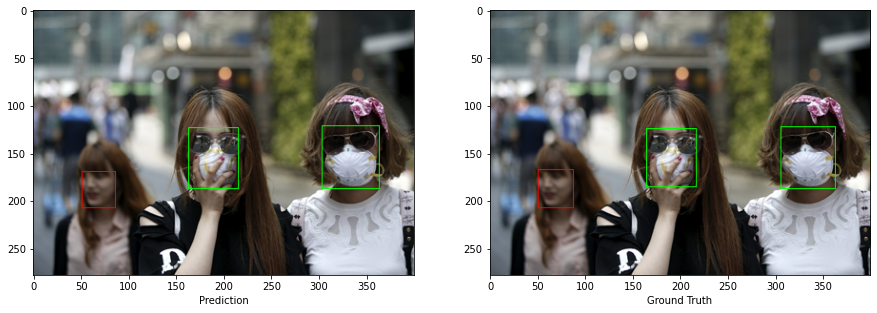

In [19]:
#idx = random.randint(1,len(file_list))
idx = 200
test_img = Image.open(os.path.join(dir_path,file_list[idx])).convert('RGB')

# Prediction
test_img, test_boxes, test_labels = single_img_predict(test_img)
test_output = draw_boxes(test_img, test_boxes,test_labels)

# Draw the bounding box of ground truth
bbox, labels  = read_annot(file_list[idx], xml_path)
#draw bounding boxes on the image
gt_output = draw_boxes(test_img, bbox,labels)

# Display the result
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,6))
ax1.imshow(test_output)
ax1.set_xlabel('Prediction')
ax2.imshow(gt_output)
ax2.set_xlabel('Ground Truth')
plt.show()

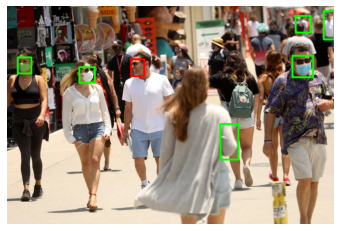

In [24]:
url = 'https://ca-times.brightspotcdn.com/dims4/default/b240c50/2147483647/strip/true/crop/6720x4480+0+0/resize/1200x800!/format/webp/quality/80/?url=https%3A%2F%2Fcalifornia-times-brightspot.s3.amazonaws.com%2F32%2F86%2F196191384a1c958a27503ed2008c%2Fla-photos-1staff-569403-me-0705-county-sees-alarming-rise-in-coronavirus-gem-005.jpg'
test_img = Image.open(requests.get(url, stream=True).raw).convert('RGB')

test_img, test_boxes, test_labels = single_img_predict(test_img)

# The image size is so large, so we increase the thickness of the bounding box
test_output = draw_boxes(test_img, test_boxes,test_labels, thickness=5)

plt.axis('off')
plt.imshow(test_output)